In [1]:
import os
import pandas as pd
from astropy import table
import matplotlib.pyplot as plt

In [2]:
dirCat=r'D:\Sources\COSMOS_photoZ\COSMOS_v3.0\catalogs\forPaper\v06'
dirCatCleaned=r'D:\Sources\COSMOS_photoZ\COSMOS_v3.0\SOM\forArticle\ex018\datasets'
fileNameCOSMOS2015=r'01_COSMOS2015_allBands.fits'
fileNameTrain=r'05_COSMOS_SpectrZ_Zlim_1p2_SOMinfo.csv'
fileNameTest=r'05_COSMOS_SpectrZ_Zlim_1p2_Test_SOMinfo.csv'
fileNameRun=r'04_COSMOS2015_run_WorkBands_SOMinfo.csv'

In [3]:
train=pd.read_csv(os.path.join(dirCatCleaned,fileNameTrain))
test=pd.read_csv(os.path.join(dirCatCleaned,fileNameTest))
run=pd.read_csv(os.path.join(dirCatCleaned,fileNameRun))
tabCOSMOS2015=table.Table.read(os.path.join(dirCat,fileNameCOSMOS2015),format='fits')
tabCOSMOS2015=tabCOSMOS2015.to_pandas()

In [4]:
# Limit narrow-band errors
data=tabCOSMOS2015
errCols=list(c for c in data.columns if ('ap3' in c and ('IA' in c or 'IB' in c or 'NB' in c) and 'e_' in c))
for c in errCols:
    data=data[data[c]>=0]
    data=data[data[c]<1]

In [5]:
print(len(tabCOSMOS2015))
print(len(data))

518404
196075


In [6]:
# Leave only the narrow bands + Seq column for merging
NbCols=['Seq']+list(c for c in data.columns if ('ap3' in c and ('IA' in c or 'IB' in c or 'NB' in c) and 'e_' not in c))
data=data[NbCols]

In [7]:
# Concatenate train, test and run
[test.drop(c,inplace=True,axis=1) for c in (set(train.columns)-set(run.columns))]
[train.drop(c,inplace=True,axis=1) for c in (set(train.columns)-set(run.columns))]
KB=run.append(train,ignore_index=True,sort=False).append(test,ignore_index=True,sort=False)

In [8]:
print(len(KB))

214398


In [13]:
KB.drop('IB574ap3',inplace=True,axis=1)
KB.columns

Index(['Seq', 'photoZ_ML', 'RAJ2000', 'DEJ2000', 'Ksmagap3', 'Ymagap3',
       'Hmagap3', 'Jmagap3', 'Bmagap3', 'Vmagap3', 'ipmagap3', 'rmagap3',
       'umagap3', 'zppmagap3', 'photoZ_SED', 'sc_Ksmagap3', 'sc_Ymagap3',
       'sc_Hmagap3', 'sc_Jmagap3', 'sc_Bmagap3', 'sc_Vmagap3', 'sc_ipmagap3',
       'sc_rmagap3', 'sc_umagap3', 'sc_zppmagap3', 'residML_SED',
       'w_sc_Ksmagap3', 'w_sc_Ymagap3', 'w_sc_Hmagap3', 'w_sc_Jmagap3',
       'w_sc_Bmagap3', 'w_sc_Vmagap3', 'w_sc_ipmagap3', 'w_sc_rmagap3',
       'w_sc_umagap3', 'w_sc_zppmagap3', 'quantErr', 'cellID_TrainSOM',
       'cellID_RunSOM', 'cellID_RunBigSOM', 'photoZ_ML_outlCoeff',
       'photoZ_SED_outlCoeff', 'quantErr_outlCoeff', 'trainMapOccupation'],
      dtype='object')

In [14]:
# Remove objects with photoZ_SED>1.2
KB=KB[KB['photoZ_SED']<1.2]
# Merge old photometry with narrow band photometry
KB=KB.merge(data,how='inner',left_on='Seq',right_on='Seq')
# Remove objects with photoZ_SED_outlCoeff>1, trainMapOccupation<5
KBclean=KB[KB['photoZ_SED_outlCoeff'].abs()<1]
KBclean=KBclean[KBclean['trainMapOccupation']>5]

In [15]:
print(len(KB))
print(len(KBclean))

110322
43009


(array([0.08179273, 0.46756143, 0.470003  , 0.94610994, 0.91192791,
        1.599231  , 1.48569781, 0.96198018, 1.1670724 , 0.91803184,
        1.18416341, 1.58213998, 0.99494142, 0.98639592, 0.88751217,
        0.90460319, 0.52493842, 0.21852088, 0.24659898, 0.21119616]),
 array([0.005 , 0.0647, 0.1244, 0.1841, 0.2438, 0.3035, 0.3632, 0.4229,
        0.4826, 0.5423, 0.602 , 0.6617, 0.7214, 0.7811, 0.8408, 0.9005,
        0.9602, 1.0199, 1.0796, 1.1393, 1.199 ]),
 <a list of 20 Patch objects>)

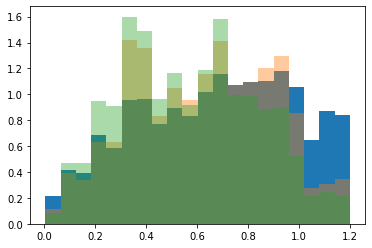

In [16]:
plt.hist(KB['photoZ_SED'],bins=20,density=True)
plt.hist(KBclean['photoZ_SED'],bins=20,density=True,alpha=0.4)
plt.hist(train[train['photoZ_SED']<1.2]['photoZ_SED'],bins=20,density=True,alpha=0.4)

In [17]:
len(KBclean)

43009

In [18]:
# Prepare datasets of different sizes and saving them
catPrefix='06_SEDasTarget_'
setSize=[len(train)+len(test),
         len(KBclean)-(len(train)+len(test)),
         len(KBclean)-(len(train)+len(test))//2,
         len(KBclean)]
for n in setSize:
    d=KB.sample(n)
    d.to_csv(os.path.join(dirCat,
                           catPrefix+'KB_'+str(n)+'.csv'), index=False)
    d=KBclean.sample(n)
    d.to_csv(os.path.join(dirCat,
                           catPrefix+'KBclean_'+str(n)+'.csv'), index=False)
n=len(KB)
d=KB.sample(n)
d.to_csv(os.path.join(dirCat,catPrefix+'KB_'+str(n)+'.csv'), index=False)